In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Flatten, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate, Input
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load the dataset
file_path_csv = 'dataset/gold_prices_with_news.csv'
data = pd.read_csv(file_path_csv)

# Combine all headlines for each date into a single text
data['Headlines'] = data[['Headline 1', 'Headline 2', 'Headline 3', 'Headline 4']].apply(lambda x: ' '.join(x.dropna()), axis=1)

# Extract relevant columns
data = data[['Date', 'Closing Price', 'Headlines']]

# Convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Sort by date
data = data.sort_values('Date')

# Fill missing headlines with empty string
data['Headlines'] = data['Headlines'].fillna('')

In [3]:
data

,Date,Closing Price,Headlines
0,2019-01-01,1281.30,gold dips as renewed risk appetite lifts asian...
1,2019-01-02,1285.91,"gold gains on global growth fears, falling asi..."
2,2019-01-03,1295.26,gold climbs to over 6-month peak on global slo...
3,2019-01-04,1284.89,gold slides after solid jobs data; palladium c...
4,2019-01-07,1288.93,gold holds steady as fed rate pause bets weigh...
...,...,...,...
1001,2022-11-04,1681.30,gold soars as u.s. jobs data raises fed slowdo...
1002,2022-11-07,1674.60,gold flat as investors seek direction from u.s...
1003,2022-11-08,1711.60,gold steadies near 1-month peak ahead of u.s. ...
1004,2022-11-09,1705.35,gold traders in wait-and-watch mode ahead of u...


In [4]:
data.tail()

,Date,Closing Price,Headlines
1001,2022-11-04,1681.30,gold soars as u.s. jobs data raises fed slowdo...
1002,2022-11-07,1674.60,gold flat as investors seek direction from u.s...
1003,2022-11-08,1711.60,gold steadies near 1-month peak ahead of u.s. ...
1004,2022-11-09,1705.35,gold traders in wait-and-watch mode ahead of u...
1005,NaT,NaN,dovish fed cues propel gold to 9-month peak go...


In [5]:
# Sentiment Analysis
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Topic Modeling
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data['Headlines'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf)
data['Topic'] = lda.transform(X_tfidf).argmax(axis=1)

In [7]:
# Named Entity Recognition (NER)
nlp = spacy.load('en_core_web_sm')
data['Entities'] = data['Headlines'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])


In [8]:
# Prepare Data for LSTM Model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Headlines'])
sequences = tokenizer.texts_to_sequences(data['Headlines'])
word_index = tokenizer.word_index

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [9]:
# Normalize the target variable
scaler = MinMaxScaler()
data['Closing Price Scaled'] = scaler.fit_transform(data[['Closing Price']])

In [10]:
# Use the closing price of the previous day as the target
y = data['Closing Price Scaled'].shift(-1).fillna(method='ffill')

# Create sequences for the LSTM model with a window size
window_size = 5
X_windowed = []
y_windowed = []


In [11]:
# Prepare sentiment scores as a feature
sentiment_scores = data['Sentiment'].values

# Example: Binary feature for the presence of a specific entity (e.g., "Gold")
data['Contains_Gold'] = data['Entities'].apply(lambda entities: any('Gold' in entity for entity in entities))
named_entity_features = data[['Contains_Gold']].values

# Combine with sentiment scores and entity features
combined_features = np.hstack((X, sentiment_scores.reshape(-1, 1), named_entity_features))

In [12]:
for i in range(len(combined_features) - window_size):
    X_windowed.append(combined_features[i:i + window_size])
    y_windowed.append(y.iloc[i + window_size])

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [13]:
def create_model(model_type):
    # Define input layers
    headline_input = Input(shape=(window_size, maxlen), name='headline_input')
    sentiment_input = Input(shape=(window_size, 1), name='sentiment_input')
    entity_input = Input(shape=(window_size, 1), name='entity_input')
    
     # Embedding and LSTM for headlines
    x = TimeDistributed(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=maxlen))(headline_input)

    if model_type == 'Bi-LSTM':
        x = TimeDistributed(Bidirectional(LSTM(100, return_sequences=True)))(x)
    elif model_type == 'CNN':
        x = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(x)
        x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    elif model_type == 'RNN':
        x = TimeDistributed(GRU(100, return_sequences=True))(x)
    else:
        raise ValueError("Invalid model type. Choose from 'Bi-LSTM', 'CNN', or 'RNN'.")

    x = TimeDistributed(Dropout(0.2))(x)
    x = TimeDistributed(Flatten())(x)

    combined = Concatenate(axis=-1)([x, sentiment_input, entity_input])
    
     # Further LSTM layers
    combined = LSTM(100)(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1)(combined)

    # Define and compile the model
    model = tf.keras.Model(inputs=[headline_input, sentiment_input, entity_input], outputs=output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [14]:
def train_and_evaluate(model, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    history = model.fit(
        [X_train[:, :, :maxlen], X_train[:, :, maxlen].reshape(-1, window_size, 1), X_train[:, :, maxlen + 1].reshape(-1, window_size, 1)],
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=([X_test[:, :, :maxlen], X_test[:, :, maxlen].reshape(-1, window_size, 1), X_test[:, :, maxlen + 1].reshape(-1, window_size, 1)], y_test),
        callbacks=[early_stopping]
    )

    # Predicting on the test set
    y_pred = model.predict([X_test[:, :, :maxlen], X_test[:, :, maxlen].reshape(-1, window_size, 1), X_test[:, :, maxlen + 1].reshape(-1, window_size, 1)])

    # Inverse transform the predicted values to original scale
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    print(f'{model_name} - Mean Squared Error: {mse}')

    return y_test_inverse, y_pred_inverse, mse, history


In [15]:
# Train and evaluate Bi-LSTM model
bi_lstm_model = create_model('Bi-LSTM')
y_test_inverse_bi_lstm, y_pred_inverse_bi_lstm, mse_bi_lstm, history_bi_lstm = train_and_evaluate(bi_lstm_model, 'Bi-LSTM')

Epoch 1/100
25/25 [==============================] - 21s 711ms/step - loss: 0.1759 - val_loss: 0.0554
Epoch 2/100
25/25 [==============================] - 17s 684ms/step - loss: 0.0298 - val_loss: 0.0127
Epoch 3/100
25/25 [==============================] - 17s 663ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 4/100
25/25 [==============================] - 16s 655ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/100
25/25 [==============================] - 17s 692ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 6/100
25/25 [==============================] - 17s 701ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/100
25/25 [==============================] - 18s 730ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 8/100
25/25 [==============================] - 18s 736ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/100
25/25 [==============================] - 18s 727ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 10/100
25/25 [==============================] - 18s 712ms/step - loss: 0.001

In [16]:


# Train and evaluate CNN model
cnn_model = create_model('CNN')
y_test_inverse_cnn, y_pred_inverse_cnn, mse_cnn, history_cnn = train_and_evaluate(cnn_model, 'CNN')

Epoch 1/100
25/25 [==============================] - 5s 106ms/step - loss: 0.0867 - val_loss: 0.0409
Epoch 2/100
25/25 [==============================] - 2s 95ms/step - loss: 0.0263 - val_loss: 0.0143
Epoch 3/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 4/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 5/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/100
25/25 [==============================] - 2s 87ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/100
25/25 [==============================] - 2s 90ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/100
25/25 [==============================] - 2s 86ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/100
25/25 [==============================] - 2s 87ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0021 - val_loss: 0.001

In [17]:
740.84/len(X_train)

0.92605

In [18]:


# Train and evaluate RNN model
rnn_model = create_model('RNN')
y_test_inverse_rnn, y_pred_inverse_rnn, mse_rnn, history_rnn = train_and_evaluate(rnn_model, 'RNN')


Epoch 1/100
25/25 [==============================] - 9s 262ms/step - loss: 0.0752 - val_loss: 0.0251
Epoch 2/100
25/25 [==============================] - 6s 241ms/step - loss: 0.0119 - val_loss: 0.0074
Epoch 3/100
25/25 [==============================] - 6s 241ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 4/100
25/25 [==============================] - 6s 245ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/100
25/25 [==============================] - 6s 244ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/100
25/25 [==============================] - 6s 245ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
25/25 [==============================] - 6s 241ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/100
25/25 [==============================] - 6s 239ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 9/100
25/25 [==============================] - 6s 233ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 10/100
25/25 [==============================] - 6s 232ms/step - loss: 0.0019 - val_lo

In [19]:
# x = [1,2,3,4,5,6]
# dates =['2nd feb','3rd feb','4th feb','5th feb','6th feb','7th feb']
# y = [-0.24,0.78,-0.04,0.78,0.48,-0.78]
# z = np.array([1870,1700,1755,1800,1850,1900])
# maxz= max(z)
# z = z/maxz
# plt.bar(x,y,label='sentiment')
# plt.plot(x,z,'r',label='predicted price * '+ str(maxz))
# plt.scatter(x,z)
# plt.xticks(x,dates)
# plt.grid()
# plt.legend()

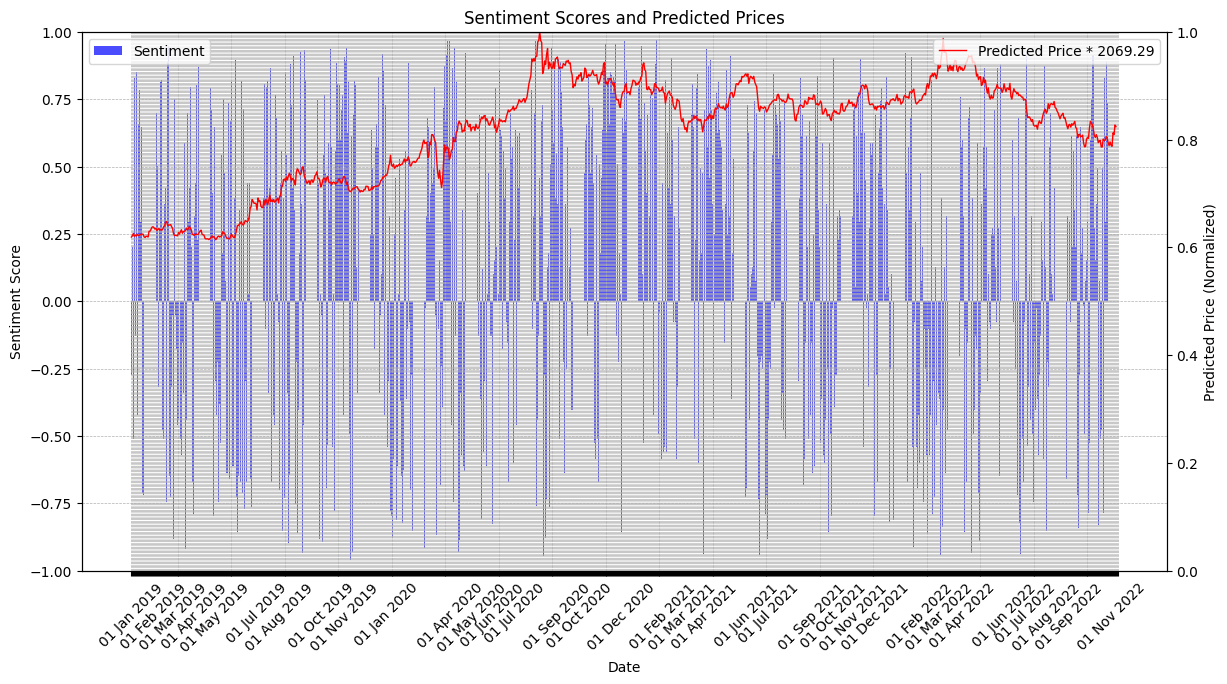

In [20]:
# Normalize closing prices for visualization
max_price = data['Closing Price'].max()
data['Normalized Price'] = data['Closing Price'] / max_price

# Prepare data for plotting
dates = data['Date'].dt.strftime('%d %b %Y').astype(str).tolist()
sentiment_scores = data['Sentiment'].tolist()
normalized_prices = data['Normalized Price'].tolist()
closing_prices = data['Closing Price'].tolist()

# Select dates at the start of each month for x-axis labels  
monthly_dates = data['Date'].dt.to_period('M').drop_duplicates().dt.to_timestamp().dt.strftime('%d %b %Y').tolist()

# Prepare a new list of x-axis labels to avoid clutter
selected_dates = [date if date in monthly_dates else '' for date in dates]

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for sentiment scores
ax1.bar(dates, sentiment_scores, label='Sentiment', alpha=0.7, color='blue')
ax1.set_ylabel('Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_xticks(np.arange(len(dates)))
ax1.set_xticklabels(selected_dates, rotation=45)
ax1.set_ylim([-1, 1])
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left')

# Line plot for predicted prices
ax2 = ax1.twinx()
ax2.plot(dates, normalized_prices, 'r-', label='Predicted Price * ' + str(max_price), linewidth=1.0)
ax2.set_ylabel('Predicted Price (Normalized)')
ax2.set_ylim([0, 1])
ax2.legend(loc='upper right')

plt.title('Sentiment Scores and Predicted Prices')
plt.show()

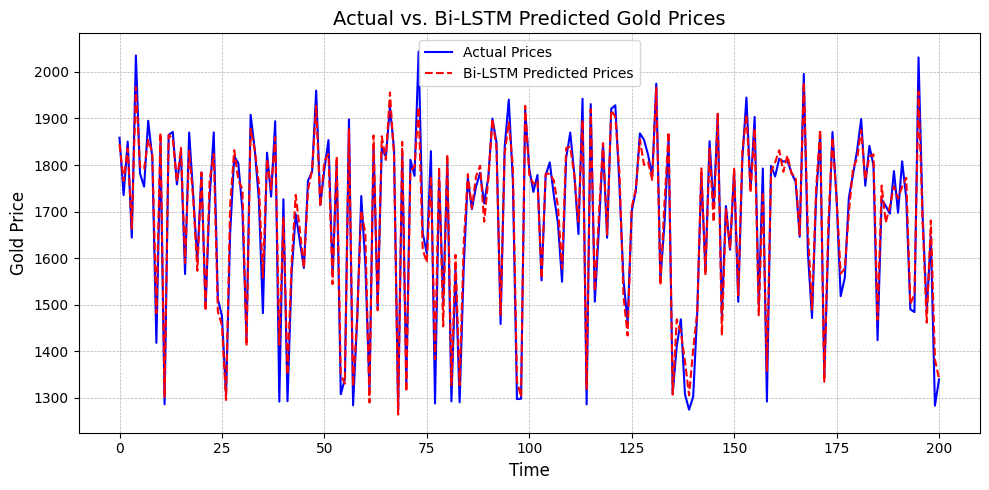

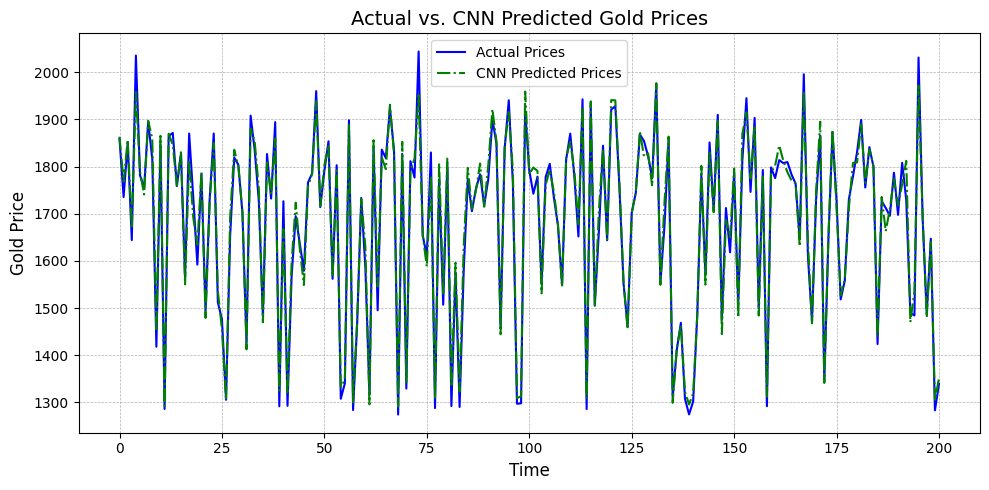

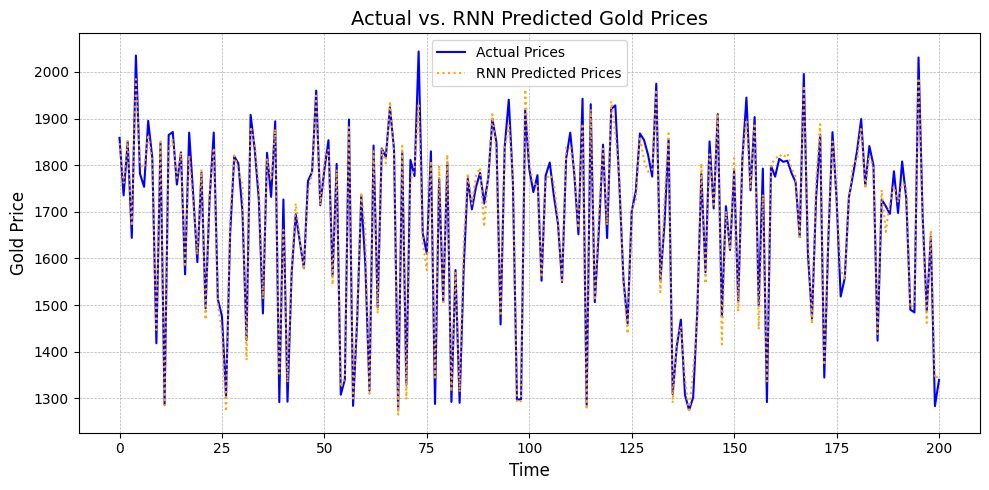

In [21]:
import matplotlib.pyplot as plt

# Assuming y_test_inverse_bi_lstm, y_pred_inverse_bi_lstm, y_pred_inverse_cnn, y_pred_inverse_rnn are defined
# Replace these with your actual data variables if different

# Plot for Bi-LSTM Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_bi_lstm)), y_pred_inverse_bi_lstm, label='Bi-LSTM Predicted Prices', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. Bi-LSTM Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Plot for CNN Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_cnn)), y_pred_inverse_cnn, label='CNN Predicted Prices', color='green', linestyle='-.', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. CNN Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Plot for RNN Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inverse_bi_lstm)), y_test_inverse_bi_lstm, label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_pred_inverse_rnn)), y_pred_inverse_rnn, label='RNN Predicted Prices', color='orange', linestyle=':', linewidth=1.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gold Price', fontsize=12)
plt.title('Actual vs. RNN Predicted Gold Prices', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()
